In [1]:
# import the necessary libraries

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Import, EDA and Pre-Processing

In [2]:
house_data = pd.read_csv("datasets/kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [4]:
incident_data = pd.read_csv("datasets/KCSO_Incident_Dataset__Historic_to_2019.csv")
incident_data.head()

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location
0,C19046940,12/09/2019 09:02:00 AM,Other,503,1 Block AVE & YESLER WAY,SEATTLE,WA,98104,12/12/2019 06:19:00 PM,12/12/2019 08:07:00 PM,9,Monday,NaN
1,C19046039,12/02/2019 06:01:00 PM,Other,162,19700 Block 635TH PL NE,BARING,WA,98224,12/05/2019 05:15:00 PM,12/05/2019 07:06:00 PM,18,Monday,NaN
2,C19026684,07/14/2019 01:29:00 AM,Vehicle Recovery,311,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,07/15/2019 05:45:00 AM,07/15/2019 06:09:00 PM,1,Sunday,NaN
3,C19043968,11/16/2019 10:07:00 PM,Traffic,404,RAINIER AVE N & RENTON AVE S,SKYWAY,WA,98178,11/19/2019 04:30:00 PM,11/19/2019 06:16:00 PM,22,Saturday,NaN
4,C19042199,11/04/2019 07:18:00 AM,Property Crime,313,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,11/05/2019 04:35:00 PM,11/05/2019 06:26:00 PM,7,Monday,NaN


In [5]:
incident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20449 entries, 0 to 20448
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   case_number              20449 non-null  object
 1   incident_datetime        20449 non-null  object
 2   incident_type            20449 non-null  object
 3   FCR                      20449 non-null  int64 
 4   address_1                20449 non-null  object
 5   city                     20449 non-null  object
 6   state                    20449 non-null  object
 7   zip                      20133 non-null  object
 8   created_at               20449 non-null  object
 9   updated_at               20449 non-null  object
 10  hour_of_day              20449 non-null  int64 
 11  day_of_week              20449 non-null  object
 12  Incident Block Location  17713 non-null  object
dtypes: int64(2), object(11)
memory usage: 2.0+ MB


In [6]:
clean_date = house_data.date.apply(lambda x: x.split('T')[0])
clean_date

0        20141013
1        20141209
2        20150225
3        20141209
4        20150218
           ...   
21608    20140521
21609    20150223
21610    20140623
21611    20150116
21612    20141015
Name: date, Length: 21613, dtype: object

In [7]:
# replace date column with the clean_date

house_data["date"] = clean_date
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
# convert price to integers as pennies are irrelevant when dealing with high prices

house_data.price = house_data.price.astype(np.int64)

In [9]:
# check to see if price has been converted to integer

house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [10]:
# select columns to plot to check for outliers using scatterplots

cols_to_plot = house_data[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]

Graph for Price: Total = 4028


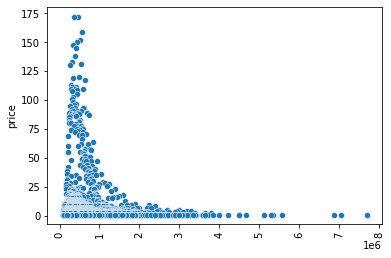

Graph for Bedrooms: Total = 13


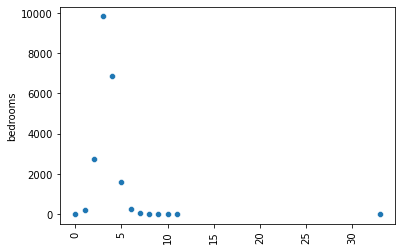

Graph for Bathrooms: Total = 30


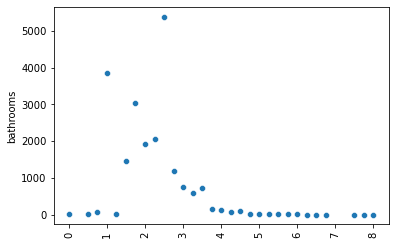

Graph for Sqft_living: Total = 1038


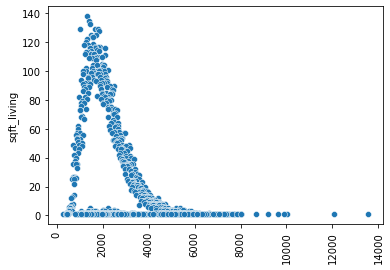

Graph for Sqft_lot: Total = 9782


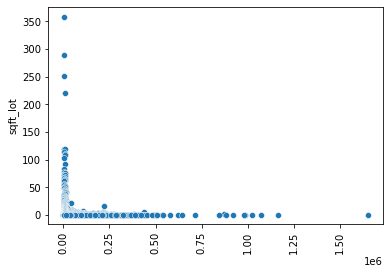

Graph for Floors: Total = 6


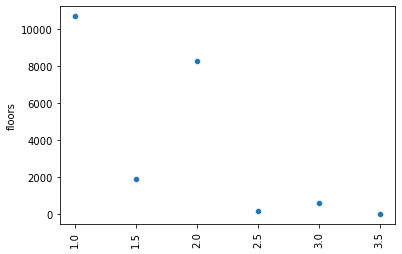

Graph for Waterfront: Total = 2


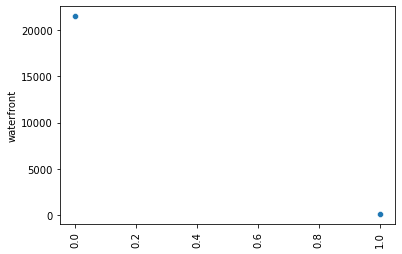

Graph for View: Total = 5


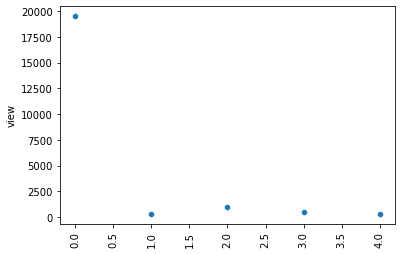

Graph for Condition: Total = 5


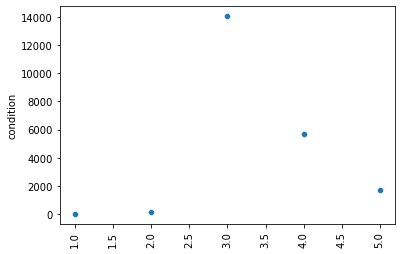

Graph for Grade: Total = 12


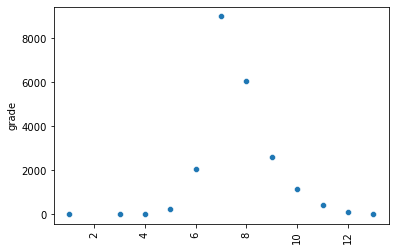

Graph for Sqft_above: Total = 946


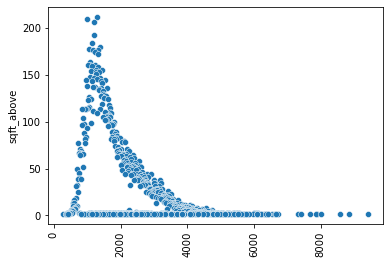

Graph for Sqft_basement: Total = 306


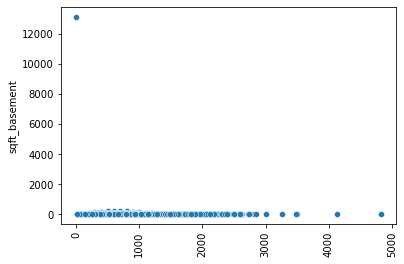

Graph for Yr_built: Total = 116


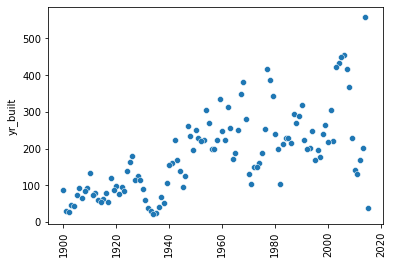

Graph for Yr_renovated: Total = 70


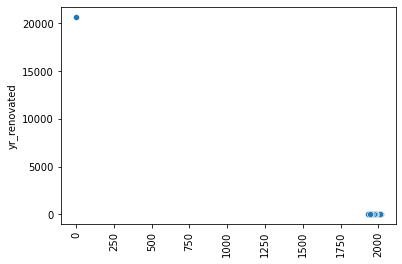

Graph for Zipcode: Total = 70


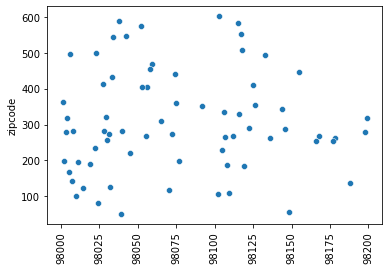

Graph for Lat: Total = 5034


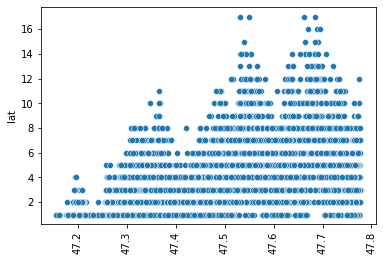

Graph for Long: Total = 752


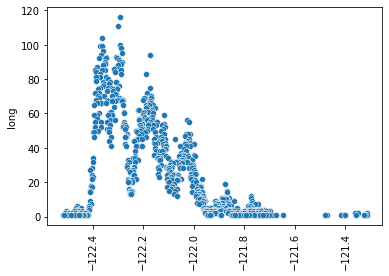

Graph for Sqft_living15: Total = 777


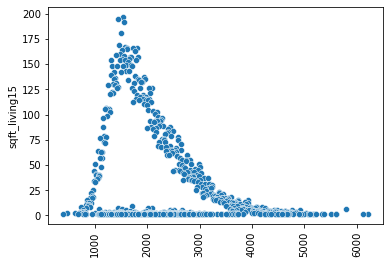

Graph for Sqft_lot15: Total = 8689


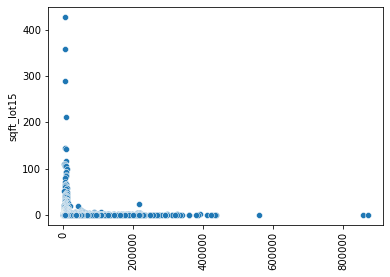

In [11]:
# Function to plot scatterplots

def plot_scatterplots():
    for i in cols_to_plot.columns:
        cat_num = cols_to_plot[i].value_counts()
        print('Graph for {}: Total = {}'.format(i.capitalize(), len(cat_num)))
        sns.scatterplot(x=cat_num.index, y=cat_num)
        plt.xticks(rotation=90)
        plt.show()
        
plot_scatterplots()

In [12]:
# remove outliers for price (over 4mil)

house_data = house_data[house_data.price < 4000000]

In [13]:
# remove outliers for bedrooms (0, 10, 11, 33) a house with 0 makes no sense and anything >= 10 is rare

house_data = house_data[house_data.bedrooms < 10]
house_data = house_data[house_data.bedrooms > 0]

In [14]:
# remove outliers for bathrooms (0) makes no sense if a house has none

house_data = house_data[house_data.bathrooms  > 0]

In [15]:
# convert those with yr_renovated == 0 to yr_built

house_data["yr_renovated"] = [house_data.iloc[i]["yr_renovated"].item() if house_data.iloc[i]["yr_renovated"].item() > 0 else house_data.iloc[i]["yr_built"].item() for i in range(len(house_data))]
# house_data.drop(["yr_renovated"], axis=1, inplace=True)
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,1987,98074,47.6168,-122.045,1800,7503


<AxesSubplot:>

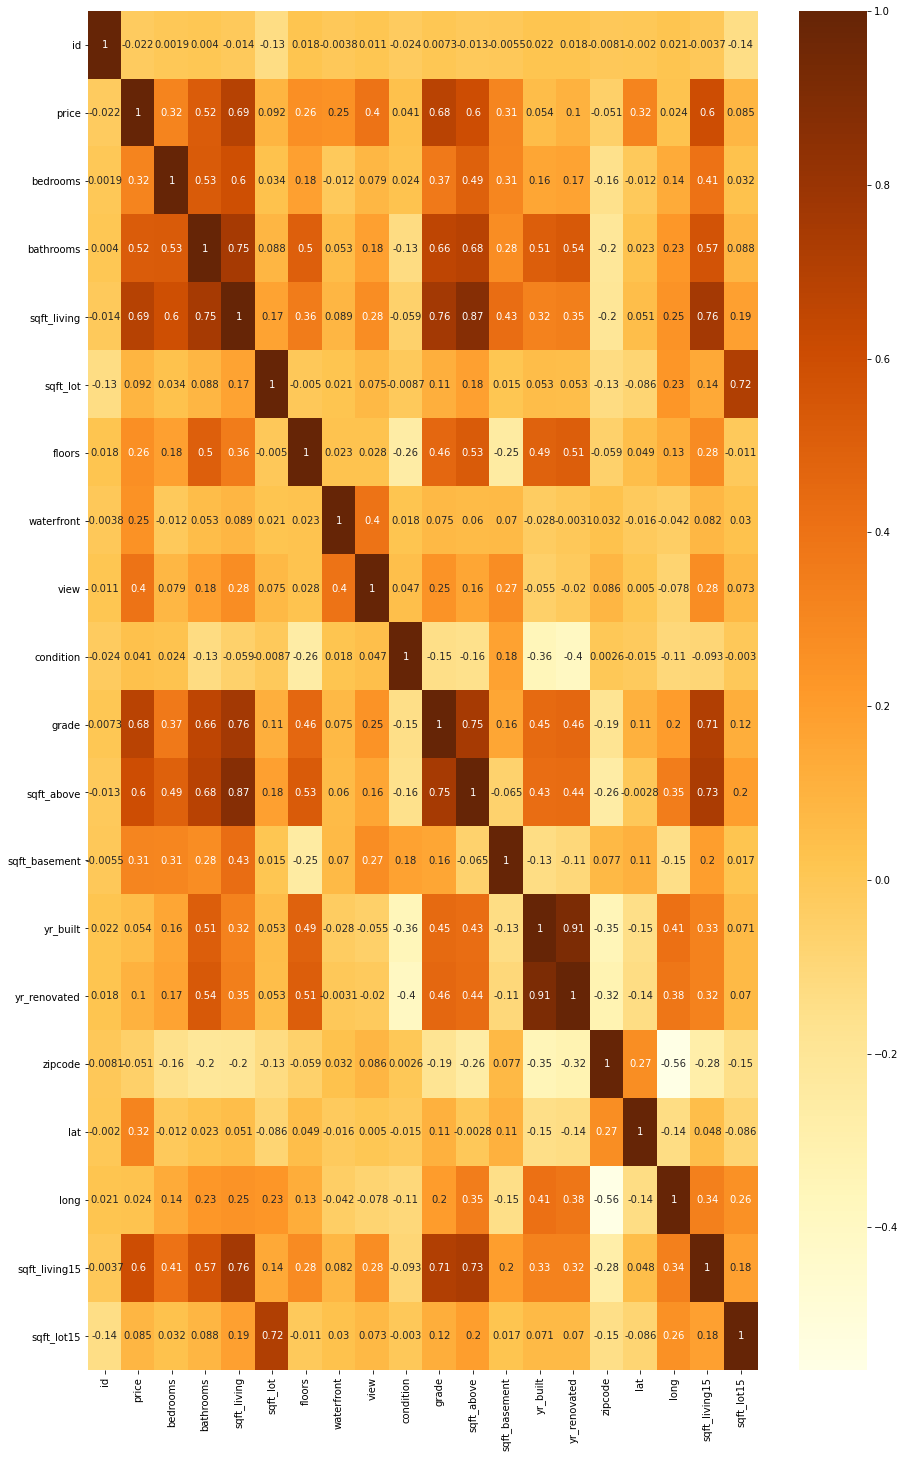

In [16]:
plt.figure(figsize=(15,25))
sns.heatmap(house_data.corr(), cmap='YlOrBr', annot=True)

In [17]:
house_data.corr()["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.694169
grade            0.677954
sqft_above       0.598528
sqft_living15    0.597643
bathrooms        0.520704
view             0.397441
lat              0.320167
bedrooms         0.319325
sqft_basement    0.312332
floors           0.264197
waterfront       0.248995
yr_renovated     0.104396
sqft_lot         0.092248
sqft_lot15       0.084846
yr_built         0.054020
condition        0.040500
long             0.024469
id              -0.022166
zipcode         -0.051256
Name: price, dtype: float64

In [18]:
# filter and create a new df for crime incidences that occurred since 2000

filtered_incidences = []
for i in range(len(incident_data["incident_datetime"])):
    curr_datetime = incident_data["incident_datetime"][i]
    datetime_split = curr_datetime.split()
    curr_date = datetime.datetime.strptime(datetime_split[0], "%m/%d/%Y")
    if curr_date.year >= 2000 and curr_date.year <= 2015:
        curr_row = incident_data.iloc[i]
        temp = [curr_date.year, curr_row["zip"]]
        filtered_incidences.append(temp)
filtered_incidences_df = pd.DataFrame(filtered_incidences, columns=["year", "zip"])

In [19]:
def add_to_dict(dict_add, key):
    if key not in dict_add:
        dict_add[key] = 1
    else:
        dict_add[key] += 1

In [20]:
# create ref dict for cumulative crime numbers per year and zipcode

filtered_dict = {2014:{}, 2015:{}}
for i in range(len(filtered_incidences_df)):
    year, zip_code = filtered_incidences_df.iloc[i]["year"], filtered_incidences_df.iloc[i]["zip"]
    if not math.isnan(float(zip_code)):
        if year == 2015:
            add_to_dict(filtered_dict[2015], zip_code)
        else:
            add_to_dict(filtered_dict[2014], zip_code)
            add_to_dict(filtered_dict[2015], zip_code)
filtered_dict

{2014: {'89103': 1,
  '98077': 2,
  '98058': 5,
  '98038': 2,
  '98024': 3,
  '98118': 1,
  '98144': 1,
  '98045': 1,
  '98101': 1,
  '98146': 2,
  '98065': 1,
  '98001': 5,
  '98051': 1,
  '98019': 1,
  '98168': 1,
  '98059': 1,
  '98014': 1,
  '98105': 1,
  '98106': 1,
  '98022': 1,
  '98037': 1,
  '98074': 1,
  '98070': 2,
  '98104': 1,
  '98056': 1,
  '98023': 1},
 2015: {'89103': 1,
  '98077': 2,
  '98058': 6,
  '98038': 2,
  '98024': 3,
  '98042': 1,
  '98118': 1,
  '98144': 1,
  '98045': 1,
  '98101': 1,
  '98146': 2,
  '98065': 1,
  '98001': 5,
  '98051': 1,
  '98178': 2,
  '98019': 1,
  '98168': 1,
  '98072': 1,
  '98059': 2,
  '98105': 2,
  '98014': 1,
  '98106': 1,
  '98022': 1,
  '98037': 1,
  '98074': 1,
  '98070': 2,
  '98104': 1,
  '98053': 1,
  '98056': 1,
  '98023': 1}}

In [21]:
# create copy of house data for crime numbers to be included later

house_data_with_crime = house_data.copy()
house_data_with_crime.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,1987,98074,47.6168,-122.045,1800,7503


In [22]:
# create column for no. of crimes for house data with crime numbers

crime_numbers = []
for i in range(len(house_data_with_crime)):
    date, zip_code = house_data_with_crime.iloc[i]["date"], str(house_data_with_crime.iloc[i]["zipcode"])
    curr_year = datetime.datetime.strptime(date, "%Y%m%d").year
    if zip_code not in filtered_dict[curr_year]:
        crime_numbers.append(0)
    else:
        crime_numbers.append(filtered_dict[curr_year][zip_code])
house_data_with_crime["no_of_crimes"] = crime_numbers

# can use below line to check if crime number corresponds to 98058 using ref dict (that was created earlier)
# house_data_with_crime[house_data_with_crime["zipcode"] == 98058]

In [23]:
# drop id and date for both dataframes as they do not provide much value
# (can consider implementing) however, first create columns for year, month & day before dropping date column

# house_data["date"] = pd.to_datetime(house_data["date"])
# house_data["year"] = house_data["date"].dt.year
# house_data["month"] = house_data["date"].dt.month
# house_data["day"] = house_data["date"].dt.day
# house_data_with_crime["date"] = pd.to_datetime(house_data_with_crime["date"])
# house_data_with_crime["year"] = house_data_with_crime["date"].dt.year
# house_data_with_crime["month"] = house_data_with_crime["date"].dt.month
# house_data_with_crime["day"] = house_data_with_crime["date"].dt.day
house_data.drop(["id", "date"], axis=1, inplace=True)
house_data_with_crime.drop(["id", "date"], axis=1, inplace=True)

In [24]:
house_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,98028,47.7379,-122.233,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,98136,47.5208,-122.393,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,98074,47.6168,-122.045,1800,7503


In [25]:
house_data_with_crime.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,no_of_crimes
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650,0
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,0
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,98028,47.7379,-122.233,2720,8062,0
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,98136,47.5208,-122.393,1360,5000,0
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,98074,47.6168,-122.045,1800,7503,1


# Train Test Split

**For house data w/o crime numbers**

In [26]:
X = house_data.iloc[:,1:].values
y = house_data.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)

**For house data with crime numbers**

In [27]:
X_2 = house_data_with_crime.iloc[:,1:].values
y_2 = house_data_with_crime.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=84)

**Scaling features**

In [28]:
scaler = MinMaxScaler()

In [29]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

# Linear Regression

In [31]:
regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)
train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv = 5)), 4)}")

Evaluation Metrics for LR
MAE: 120776.10030194833
MSE: 37314940732.26143
RMSE: 193170.75537529337
R-squared score for train: 0.7100168811780134
Adjusted R-squared score for train: 0.7097747914725825
R-squared score for test: 0.6990749616753597
Adjusted R-squared score for test: 0.6988237372103607


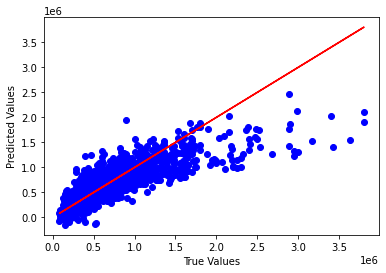

In [32]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

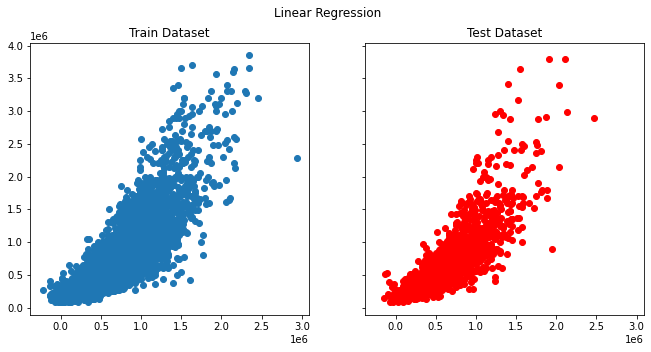

In [33]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [34]:
regression_with_crime = LinearRegression()
regression_with_crime.fit(X_train_2, y_train_2)
pred_with_crime = regression_with_crime.predict(X_test_2)
train_adjusted_r2 = 1 - (1-regression_with_crime.score(X_train_2, y_train_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression_with_crime.score(X_test_2, y_test_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
print("Evaluation Metrics for LR (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, pred_with_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, pred_with_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, pred_with_crime))}")
print(f"R-squared score for train: {regression_with_crime.score(X_train_2, y_train_2)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression_with_crime.score(X_test_2, y_test_2)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression_with_crime, X_2, y_2, cv = 5)), 4)}")

Evaluation Metrics for LR (with crime)
MAE: 120259.41139252688
MSE: 37089942256.05797
RMSE: 192587.49247045605
R-squared score for train: 0.7120730207109061
Adjusted R-squared score for train: 0.7118192817217366
R-squared score for test: 0.7008894540407722
Adjusted R-squared score for test: 0.7006258594037951


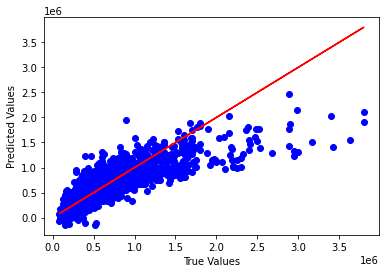

In [35]:
# For test set

# scatter for predictions
plt.scatter(y_test_2, pred_with_crime, color = "blue")
# perfect predictions
plt.plot(y_test_2, y_test_2, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

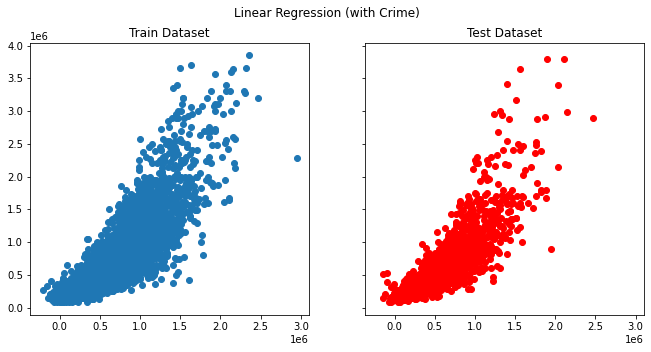

In [36]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression_with_crime.predict(X_train_2), y_train_2)
ax[1].scatter(pred_with_crime, y_test_2, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression (with Crime)')

plt.show()

# Lasso Regression

In [37]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(lasso, X, y, cv = 5)), 4)}")

Evaluation Metrics for Lasso
MAE: 120793.17804857898
MSE: 37309243116.20539
RMSE: 193156.00719678742
R-squared score for train: 0.7100143858595345
Adjusted R-squared score for train: 0.7097722940709101
R-squared score for test: 0.6991209099013618
Adjusted R-squared score for test: 0.6988697237958112


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34302131072574.875, tolerance: 207526665851.26117
  model = cd_fast.enet_coordinate_descent(


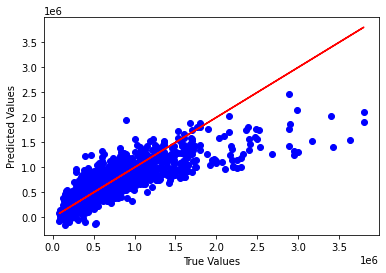

In [38]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

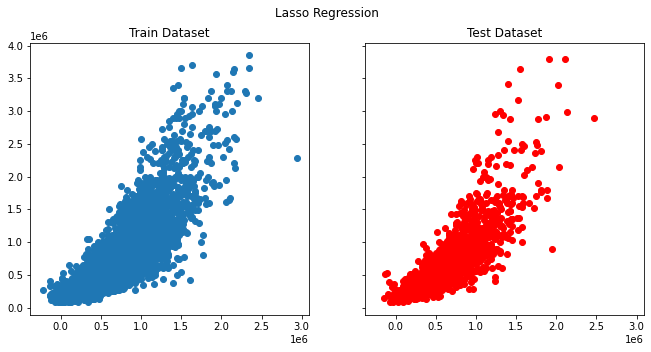

In [39]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [40]:
lasso_crime = Lasso()
lasso_crime.fit(X_train_2, y_train_2)
lasso_pred_crime = lasso_crime.predict(X_test_2)
train_adjusted_r2 = 1 - (1-lasso_crime.score(X_train_2, y_train_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso_crime.score(X_test_2, y_test_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
print("Evaluation Metrics for Lasso (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, lasso_pred_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, lasso_pred_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, lasso_pred_crime))}")
print(f"R-squared score for train: {lasso_crime.score(X_train_2, y_train_2)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso_crime.score(X_test_2, y_test_2)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(lasso_crime, X_2, y_2, cv = 5)), 4)}")

Evaluation Metrics for Lasso (with crime)
MAE: 120277.88374249384
MSE: 37085706018.079384
RMSE: 192576.4939396275
R-squared score for train: 0.7120709512324818
Adjusted R-squared score for train: 0.7118172104195605
R-squared score for test: 0.7009236170342286
Adjusted R-squared score for test: 0.7006600525037856


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34059560827068.125, tolerance: 207526665851.26117
  model = cd_fast.enet_coordinate_descent(


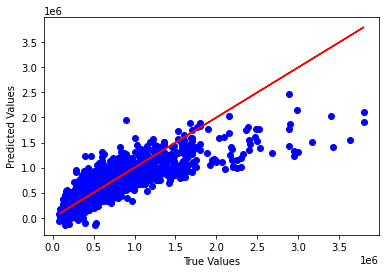

In [41]:
# For test set

# scatter for predictions
plt.scatter(y_test_2, lasso_pred_crime, color = "blue")
# perfect predictions
plt.plot(y_test_2, y_test_2, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

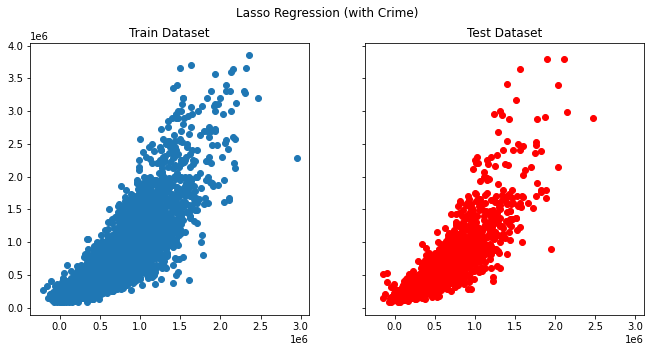

In [42]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso_crime.predict(X_train_2), y_train_2)
ax[1].scatter(lasso_pred_crime, y_test_2, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression (with Crime)')

plt.show()

# XGBoost Regression

In [43]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=700, max_depth=4, nthread=4, subsample=0.9, colsample_bytree=0.7, min_child_weight=4)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
train_adjusted_r2 = 1 - (1-xgb.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, X, y, cv = 5)), 4)}")

Evaluation Metrics for XGBoost
MAE: 67429.20736069277
MSE: 13485960654.839157
RMSE: 116129.06894847284
R-squared score for train: 0.9388519240411183
Adjusted R-squared score for train: 0.9388008751395247
R-squared score for test: 0.8912429405684836
Adjusted R-squared score for test: 0.891152145750536


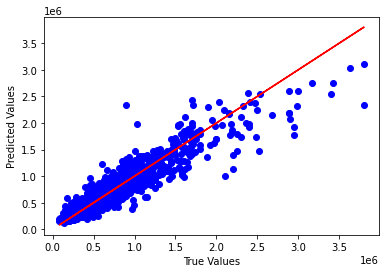

In [44]:
# For test set

# scatter for predictions
plt.scatter(y_test, xgb_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

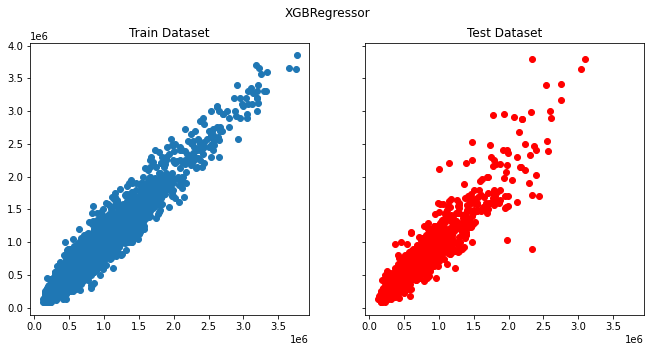

In [45]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(xgb.predict(X_train), y_train)
ax[1].scatter(xgb_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('XGBRegressor')

plt.show()

In [46]:
xgb_crime = XGBRegressor(learning_rate=0.03, n_estimators=700, max_depth=4, nthread=4, subsample=0.9, colsample_bytree=0.7, min_child_weight=4)
xgb_crime.fit(X_train_2, y_train_2)
xgb_pred_crime = xgb_crime.predict(X_test_2)
train_adjusted_r2 = 1 - (1-xgb_crime.score(X_train_2, y_train_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb_crime.score(X_test_2, y_test_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
print("Evaluation Metrics for XGBoost (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, xgb_pred_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, xgb_pred_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, xgb_pred_crime))}")
print(f"R-squared score for train: {xgb_crime.score(X_train_2, y_train_2)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb_crime.score(X_test_2, y_test_2)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb_crime, X_2, y_2, cv = 5)), 4)}")

Evaluation Metrics for XGBoost (with crime)
MAE: 67431.58910340883
MSE: 13618800153.83473
RMSE: 116699.61505435538
R-squared score for train: 0.938020394969041
Adjusted R-squared score for train: 0.93796577472342
R-squared score for test: 0.890171661061085
Adjusted R-squared score for test: 0.8900748735638754


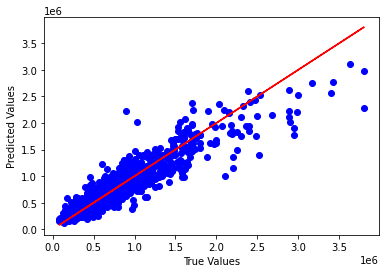

In [47]:
# For test set

# scatter for predictions
plt.scatter(y_test_2, xgb_pred_crime, color = "blue")
# perfect predictions
plt.plot(y_test_2, y_test_2, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

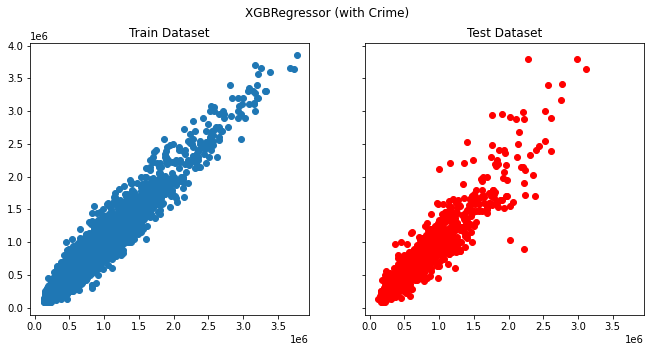

In [48]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(xgb_crime.predict(X_train_2), y_train_2)
ax[1].scatter(xgb_pred_crime, y_test_2, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('XGBRegressor (with Crime)')

plt.show()